# Практическое занятие: дообучение нейросети



Привет!

В этом практическом занятии мы будем также решать задачу классификации картинок и работать с библиотекой PyTorch.

Мы будем использовать предобученную на ImageNet сеть Vgg19 для дообучения на датасете для классификации кошек и собак.

![alt text](https://i.ytimg.com/vi/IiilA0dsciY/maxresdefault.jpg)

## 1. Загрузка датасета


Для загрузки датасета из интернета воспользуемся командами bash. Bash -- язык командной строки linux. В ячейках jupyter notebook можно запускать команды bash, предварительно написав ! в начале ячейки.

In [ ]:
# команда wget скачивает файлы из интернета по ссылке
! wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
# команда unzip разархивирует zip-архив
! unzip cats_and_dogs_filtered.zip

In [ ]:
# команда ls выводит список файлов в текущей директории
! ls

cats_and_dogs_filtered	cats_and_dogs_filtered.zip  sample_data


In [ ]:
# команда ls ИМЯ_ПАПКИ выводит список файлов в указанной папке
! ls cats_and_dogs_filtered/

train  validation  vectorize.py


In [ ]:
! ls cats_and_dogs_filtered/train

cats  dogs


In [ ]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

In [ ]:
transform_train = transforms.Compose([
         transforms.Resize((50, 50)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
         transforms.Resize((50, 50)),                           
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = datasets.ImageFolder("cats_and_dogs_filtered/train/", transform=transform_train)
test_data = datasets.ImageFolder("cats_and_dogs_filtered/validation", transform=transform_val)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: cats_and_dogs_filtered/train/
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle = False)

In [ ]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 50, 50]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

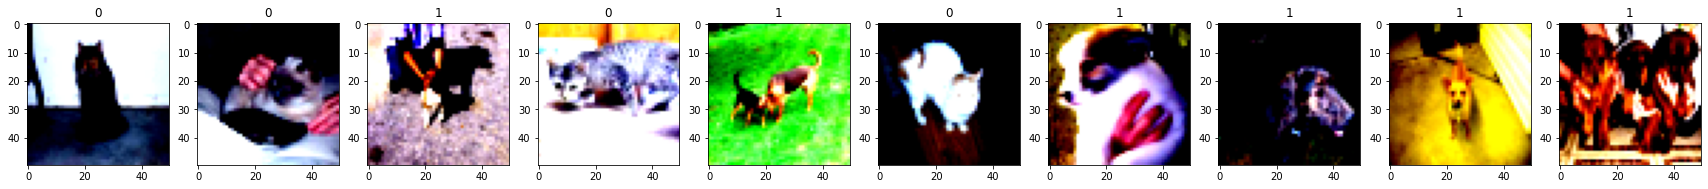

In [ ]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)


Импортируем нужные модули для обучения сети:

In [ ]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

## 2. Обучение и тест базовой сети.

Для начала построим двуслойную полносвязную нейронную сеть, обучим ее и посчитаем метрику accuracy на тестовой выборке:

<a href="https://ibb.co/prDn4RG"><img src="https://i.ibb.co/G3wFCtB/Screen-Shot-2020-03-14-at-9-43-10-PM.png" alt="Screen-Shot-2020-03-14-at-9-43-10-PM" border="0"></a>

In [ ]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.mp1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(10, 3, kernel_size=3) 
        
        self.flatten = Flatten()
        self.fc1 = nn.Linear(1452, 256)
        self.fc2 = nn.Linear(256, 2)
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.conv1(x))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        # x = self.mp2(x)
        x = self.flatten(x)
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        # print(x.shape)
        return x

Давайте вынесем код обучения сети в отдельную функцию, чтобы каждый раз при изменении сети не копировать его. Код обучения мы менять не будем.

In [ ]:
def train(net, n_epoch=5):
  # выбираем функцию потерь
  loss_fn = torch.nn.CrossEntropyLoss()

  # выбираем алгоритм оптимизации и learning_rate
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 5 эпохи
  for epoch in tqdm_notebook(range(n_epoch)):

      running_loss = 0.0
      train_dataiter = iter(train_loader)
      for i, batch in enumerate(tqdm_notebook(train_dataiter)):
          # так получаем текущий батч
          X_batch, y_batch = batch
          
          # обнуляем веса
          optimizer.zero_grad()

          # forward pass (получение ответов на батч картинок)
          y_pred = net(X_batch)
          # вычисление лосса от выданных сетью ответов и правильных ответов на батч
          loss = loss_fn(y_pred, y_batch)
          # bsckpropagation (вычисление градиентов)
          loss.backward()
          # обновление весов сети
          optimizer.step()

          # выведем текущий loss
          running_loss += loss.item()
          # выведем качество каждые 500 батчей
          if i % 10 == 9:
              print('[%d, %5d] loss: %.3f, acc: %3f' %
                    (epoch + 1, i + 1, running_loss / 500, accuracy_score(y_batch.numpy(), np.argmax(y_pred.detach().numpy(), axis=1))))
              running_loss = 0.0

  print('Обучение закончено')
  return net

In [ ]:
# объявляем сеть
net = ConvNet()
# теперь обучить сеть можно вызвав функцию train и передав туда переменную сети.
net = train(net)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,    10] loss: 0.014, acc: 0.531250
[1,    20] loss: 0.014, acc: 0.531250
[1,    30] loss: 0.014, acc: 0.500000
[1,    40] loss: 0.013, acc: 0.500000
[1,    50] loss: 0.013, acc: 0.625000
[1,    60] loss: 0.013, acc: 0.468750



[2,    10] loss: 0.013, acc: 0.718750
[2,    20] loss: 0.012, acc: 0.781250
[2,    30] loss: 0.012, acc: 0.656250
[2,    40] loss: 0.012, acc: 0.718750
[2,    50] loss: 0.013, acc: 0.625000
[2,    60] loss: 0.013, acc: 0.656250



[3,    10] loss: 0.012, acc: 0.593750
[3,    20] loss: 0.012, acc: 0.781250
[3,    30] loss: 0.012, acc: 0.750000
[3,    40] loss: 0.011, acc: 0.625000
[3,    50] loss: 0.011, acc: 0.625000
[3,    60] loss: 0.012, acc: 0.656250



[4,    10] loss: 0.011, acc: 0.781250
[4,    20] loss: 0.011, acc: 0.718750
[4,    30] loss: 0.011, acc: 0.843750
[4,    40] loss: 0.011, acc: 0.687500
[4,    50] loss: 0.011, acc: 0.593750
[4,    60] loss: 0.011, acc: 0.750000



[5,    10] loss: 0.011, acc: 0.718750
[5,    20] loss: 0.011, acc: 0.562500
[5,    30] loss: 0.011, acc: 0.781250
[5,    40] loss: 0.011, acc: 0.750000
[5,    50] loss: 0.010, acc: 0.812500
[5,    60] loss: 0.011, acc: 0.781250


Обучение закончено


Посчитаем accuracy на test:

In [ ]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.653

## 3. Дообучение VGG16 

Наша сверточная сеть не очень хорошо справляется с поставленной задачей, она переобучается Давайте попробуем дообучить сеть VGG16, обученную на ImageNet, под нашу задачу.

Список сетей, предобученных на ImageNet, которые есть в библиотеке PyTorch: https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()))[:-1]

In [ ]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
class New_VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16
        for param in self.vgg16.features.parameters():
          param.requires_grad = False
        self.fc = nn.Linear(4096, 2)
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.vgg16(x)
        x = self.fc(x)
        return x

In [ ]:
net = New_VGG16()
train(net)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[1,    10] loss: 0.041, acc: 0.750000
[1,    20] loss: 0.038, acc: 0.656250
[1,    30] loss: 0.048, acc: 0.781250
[1,    40] loss: 0.036, acc: 0.750000
[1,    50] loss: 0.030, acc: 0.718750
[1,    60] loss: 0.025, acc: 0.468750



[2,    10] loss: 0.011, acc: 0.750000
[2,    20] loss: 0.010, acc: 0.875000
[2,    30] loss: 0.011, acc: 0.843750
[2,    40] loss: 0.018, acc: 0.812500
[2,    50] loss: 0.014, acc: 0.562500
[2,    60] loss: 0.014, acc: 0.750000



[3,    10] loss: 0.012, acc: 0.781250
[3,    20] loss: 0.008, acc: 0.937500
[3,    30] loss: 0.012, acc: 0.843750
[3,    40] loss: 0.014, acc: 0.875000
[3,    50] loss: 0.010, acc: 0.750000
[3,    60] loss: 0.013, acc: 0.718750



KeyboardInterrupt: ignored

In [ ]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))

0.799

In [ ]:
class New_VGG16_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16
        for param in self.vgg16.parameters():
          param.requires_grad = False
        self.fc = nn.Linear(4096, 2)
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.vgg16(x)
        x = self.fc(x)
        return x

In [ ]:
net = New_VGG16_1()
train(net)

In [ ]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images).detach().numpy(), axis=1))